# Problem 3

In [1]:
import re
import csv
import PIL
import glob
import math
from random import uniform
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

## Functions

In [2]:
def rotate(img, angle_deg):
    angle_rad = angle_deg * math.pi / 180
    rotate_img = img.rotate(angle_deg, PIL.Image.BILINEAR)
    sin, cos = abs(math.sin(angle_rad)), abs(math.cos(angle_rad))
    crop = 64 * (cos - sin) / (cos**2 - sin**2)
    upper = left = math.ceil((64 - crop) / 2)
    lower = right = math.ceil((64 - crop) / 2 + crop)
    rotate_img = rotate_img.crop(box=(left, upper, right, lower))
    rotate_img = rotate_img.resize((64, 64), PIL.Image.BILINEAR)
    return rotate_img

In [3]:
def scale(img, factor):
    crop = 64 * (1 - factor / 100)
    upper = left = math.ceil((64 - crop) / 2)
    lower = right = math.ceil((64 - crop) / 2 + crop)
    scale_img = img.crop(box=(left, upper, right, lower))
    scale_img = scale_img.resize((64, 64), PIL.Image.BILINEAR)
    return scale_img

In [4]:
def load_train(path, augmentation=False, max_rotate=30, max_scale=50):
    filenames = [f for f in glob.glob(path + "**/*.jpg", recursive=True)]
    labels = [0 if "Cat" in f else 1 for f in filenames]
    f_train, f_valid, l_train, l_valid = train_test_split(
        filenames, labels, test_size=0.2, stratify=labels)

    x_train, x_valid, y_train, y_valid = [], [], [], []

    for file, label in zip(f_train, l_train):
        with Image.open(file) as img:
            data = list((p, p, p) if isinstance(p, int) else tuple(p)
                        for p in img.getdata())
            x_train.append(np.array(data).reshape(64, 64, 3))
            y_train.append(label)
            if augmentation:
                #scale
                scale_img = scale(img, uniform(5, max_scale))
                data = list((p, p, p) if isinstance(p, int) else tuple(p)
                            for p in scale_img.getdata())
                x_train.append(np.array(data).reshape(64, 64, 3))
                #rotate
                rotate_img = rotate(img, uniform(-max_scale, max_scale))
                data = list((p, p, p) if isinstance(p, int) else tuple(p)
                            for p in rotate_img.getdata())
                x_train.append(np.array(data).reshape(64, 64, 3))
                #flip (horizontal)
                flip_img = img.transpose(Image.FLIP_LEFT_RIGHT)
                data = list((p, p, p) if isinstance(p, int) else tuple(p)
                            for p in flip_img.getdata())
                x_train.append(np.array(data).reshape(64, 64, 3))
                y_train += [label] * 3

    for file, label in zip(f_valid, l_valid):
        img = Image.open(file)
        data = list((p, p, p) if isinstance(p, int) else tuple(p)
                    for p in img.getdata())
        x_valid.append(np.array(data).reshape(64, 64, 3))
        y_valid.append(label)

    x_train = np.asarray(x_train).swapaxes(1, 3).swapaxes(
        2, 3).astype("float32") / 255.
    x_valid = np.asarray(x_valid).swapaxes(1, 3).swapaxes(
        2, 3).astype("float32") / 255.
    y_train = np.asarray(y_train).reshape(-1, 1)
    y_valid = np.asarray(y_valid).reshape(-1, 1)

    return x_train, x_valid, y_train, y_valid

Note it is not the best way to call *augmentation_size* times the function *scale* and *rotate* (see [here](https://wiki.python.org/moin/PythonSpeed/PerformanceTips)), but it is easier to understand.

We should not do data augmentation on the validation set (to be confirm).

## Model

In [5]:
class Net(nn.Module):
    def __init__(self,
                 activation=nn.ReLU(),
                 n_filters=(8, 16, 32),
                 linear_size=100):
        super(Net, self).__init__()
        self.activation = activation
        self.n_filters = n_filters
        self.linear_size = linear_size
        self.conv = nn.Sequential(
            nn.Conv2d(
                3, self.n_filters[0], kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, 2), self.activation,
            nn.Conv2d(
                self.n_filters[0],
                self.n_filters[1],
                kernel_size=3,
                stride=1,
                padding=1), nn.MaxPool2d(2, 2), self.activation,
            nn.Conv2d(
                self.n_filters[1], self.n_filters[2], kernel_size=5, stride=1),
            nn.MaxPool2d(3, 3), self.activation)

        self.mlp = nn.Sequential(
            nn.Linear(self.n_filters[2] * 4 * 4, self.linear_size),
            self.activation, nn.Linear(self.linear_size, 1))

    def forward(self, x):
        x = self.conv(x)
        x = torch.sigmoid(self.mlp(x.view(-1, self.n_filters[2] * 4 * 4)))
        return x

    def evaluate(self, loader):
        with torch.no_grad():
            val_loss, correct, total = 0, 0, 0
            for data in loader:
                # get the inputs
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                ouputs = self(inputs)
                val_loss += criterion(ouputs, labels).item()
                total += labels.size(0)
                predicted = (ouputs > 0.5).float()
                correct += (predicted == labels).sum().item()
        return val_loss / len(loader), correct / total

    def predict(self, loader):
        predictions = []
        with torch.no_grad():
            for inputs in loader:
                inputs = inputs.to(device)
                ouputs = self(inputs)
                predictions.extend((ouputs > 0.5).float().cpu().numpy())
        return np.asarray(predictions).reshape(-1)

    def train(self,
              trainloader,
              validloader,
              patience=5,
              max_it=9999,
              verbose=True):
        counter, best_val_acc, train_loss, val_loss = 0, -1, None, None
        history = ([], [], [])
        if verbose:
            print("{:5s} | {:10s} | {:10s} | {:10s}".format(
                "epoch", "train_loss", "valid_loss", "valid_acc"))
        for epoch in range(max_it):
            running_loss = 0
            # early stopping
            counter += 1
            if counter > patience - 1:
                break
            for i, data in enumerate(trainloader, 1):
                # get the inputs
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                outputs = self.forward(inputs)
                train_loss = criterion(outputs, labels)
                running_loss += train_loss.item()
                train_loss.backward()
                optimizer.step()
            val_loss, val_acc = self.evaluate(validloader)
            if verbose:
                print(
                    "{:5d} | {:10.5f} | {:10.5f} | {:10.2%}".format(
                        epoch, running_loss / len(trainloader), val_loss,
                        val_acc),
                    end="")
            if val_acc > best_val_acc:
                counter = 0
                best_val_acc = val_acc
                torch.save(self.state_dict(), "best_model")
                if verbose:
                    print("\tsaved!", end="")
            else:
                scheduler.step()
            if verbose:
                print("")
            history[0].append(running_loss / len(trainloader))
            history[1].append(val_loss)
            history[2].append(val_acc)
        self.load_state_dict(torch.load("best_model"))
        return history

## Load data (with augmentation)

In [6]:
x_train, x_valid, y_train, y_valid = load_train("data/kaggle/trainset/", augmentation=True)

print(x_train.shape)
print(x_valid.shape)

x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
x_valid = torch.from_numpy(x_valid).float()
y_valid = torch.from_numpy(y_valid).float()

train = torch.utils.data.TensorDataset(x_train, y_train)
trainloader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)

valid = torch.utils.data.TensorDataset(x_valid, y_valid)
validloader = torch.utils.data.DataLoader(valid, batch_size=128, shuffle=False)

(63992, 3, 64, 64)
(4000, 3, 64, 64)


## Train one model (sanity check)

In [7]:
model = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Let\'s use {}".format(device))

Let's use cuda:0


In [8]:
# define loss, optimizer and lr decay globally (probably not the best way)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 1)

In [9]:
(train_loss, valid_loss, valid_acc) = model.train(trainloader, validloader)

epoch | train_loss | valid_loss | valid_acc 
    0 |    0.69264 |    0.69100 |     52.60%	saved!
    1 |    0.67862 |    0.66053 |     60.85%	saved!
    2 |    0.64642 |    0.61327 |     67.58%	saved!
    3 |    0.61125 |    0.57467 |     69.90%	saved!
    4 |    0.57876 |    0.53386 |     73.28%	saved!
    5 |    0.55017 |    0.51699 |     74.55%	saved!
    6 |    0.52822 |    0.50782 |     75.20%	saved!
    7 |    0.50455 |    0.52167 |     74.05%
    8 |    0.48521 |    0.46995 |     76.80%	saved!
    9 |    0.46969 |    0.45222 |     78.45%	saved!
   10 |    0.45333 |    0.44936 |     78.12%
   11 |    0.43716 |    0.59403 |     70.45%
   12 |    0.41873 |    0.44791 |     78.83%	saved!
   13 |    0.40986 |    0.41628 |     79.92%	saved!
   14 |    0.38956 |    0.46215 |     78.55%
   15 |    0.37301 |    0.42898 |     79.57%
   16 |    0.35930 |    0.43437 |     80.60%	saved!
   17 |    0.34212 |    0.47099 |     79.00%
   18 |    0.33145 |    0.44548 |     80.88%	saved!
   19 |  

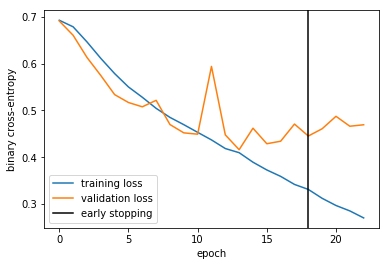

In [10]:
plt.plot(range(0, len(train_loss)), train_loss, label="training loss")
plt.plot(range(0, len(valid_loss)), valid_loss, label="validation loss")
plt.axvline(np.argmax(valid_acc), c="k", label="early stopping")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("binary cross-entropy")
plt.show()

The network start to overfit. Early stopping + load the best model allows us to avoid this problem.

## Grid Search

In [11]:
best_params, best_model, best_val_acc = None, None, -1

param_grid = {
    "lr": [0.1, 0.01, 0.001],
    "lr_decay": [1, 0.9, 0.1],
    "activation": [nn.ReLU()],
    "n_filters": [(8, 8, 16), (8, 16, 16), (8, 16, 32)],
    "linear_size": [10, 20, 100],
    "batch_size": [32, 128]
}

for params in ParameterGrid(param_grid):
    trainloader = torch.utils.data.DataLoader(
        train, params["batch_size"], shuffle=True)
    validloader = torch.utils.data.DataLoader(
        valid, params["batch_size"], shuffle=True)
    model = Net(params["activation"], params["n_filters"],
                params["linear_size"])
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), params["lr"])
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, params["lr_decay"])
    model.train(trainloader, validloader, verbose=False)
    val_acc = model.evaluate(validloader)[1]
    if val_acc > best_val_acc:
        best_model = model
        best_params = params
        best_val_acc = val_acc
        print("{}: {:.1%}".format(params, val_acc))

{'activation': ReLU(), 'batch_size': 32, 'linear_size': 10, 'lr': 0.1, 'lr_decay': 1, 'n_filters': (8, 8, 16)}: 78.6%
{'activation': ReLU(), 'batch_size': 32, 'linear_size': 10, 'lr': 0.1, 'lr_decay': 1, 'n_filters': (8, 16, 16)}: 83.2%
{'activation': ReLU(), 'batch_size': 32, 'linear_size': 100, 'lr': 0.1, 'lr_decay': 0.9, 'n_filters': (8, 16, 32)}: 83.3%
{'activation': ReLU(), 'batch_size': 32, 'linear_size': 100, 'lr': 0.1, 'lr_decay': 0.1, 'n_filters': (8, 16, 32)}: 84.0%


## Test set prediction

In [12]:
x_test, id = [], []
for file in glob.glob("data/kaggle/testset/test/*.jpg"):
    id.append(int(file[25:-4]))
    img = Image.open(file)
    data = list(
        (p, p, p) if isinstance(p, int) else tuple(p) for p in img.getdata())
    x_test.append(np.array(data).reshape(64, 64, 3))
x_test = np.asarray(x_test).swapaxes(1, 3).swapaxes(2,
                                                    3).astype("float32") / 255.
x_test = torch.from_numpy(x_test).float()
testloader = torch.utils.data.DataLoader(x_test, 1024, shuffle=False)

In [13]:
predictions = best_model.predict(testloader)

In [14]:
# sort porediction according to number
predictions = [p for _,p in sorted(zip(id,predictions))]

In [15]:
file = open("predictions.csv", "w")
writer = csv.writer(
    file, delimiter=" ", escapechar=" ", quoting=csv.QUOTE_NONE)
header = ["id,label"]
writer.writerow(header)
for i, p in enumerate(predictions, 1):
    writer.writerow(["{},{}".format(i, "Cat" if p == 0 else "Dog")])
file.close()